# 🏠 Lahore Real Estate Market Analysis
## Exploratory Data Analysis (EDA)

This notebook combines data from two major Pakistani property portals:
- **Zameen.com** - Pakistan's leading property portal
- **Graana.com** - Growing property marketplace

### 📊 Analysis Objectives:
1. **Data Integration** - Combine datasets from both sources
2. **Market Overview** - Price distributions and property types
3. **Location Analysis** - Average pricing by area/location
4. **Comparative Analysis** - Price differences between portals
5. **Market Insights** - Trends and patterns in Lahore real estate

### 🎯 Key Questions:
- Which areas have the highest property prices?
- How do prices compare between Zameen and Graana?
- What's the distribution of property types and sizes?
- Are there pricing patterns by location and property features?

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import re 
warnings.filterwarnings('ignore')

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [51]:


zameen_df = pd.read_csv('data/zameen_lahore_data.csv')
zameen_df['source'] = 'Zameen.com'
print(f"✅ Zameen.com data loaded: {len(zameen_df)} records")

graana_df = pd.read_csv('data/graana_lahore_data.csv')
graana_df['source'] = 'Graana.com'
print(f"✅ Graana.com data loaded: {len(graana_df)} records")
    


# Display basic info about each dataset
print("\n🔍 ZAMEEN.COM DATASET OVERVIEW:")
print("="*50)
print(f"Shape: {zameen_df.shape}")
print(f"Columns: {list(zameen_df.columns)}")
print("\nFirst few rows:")
print(zameen_df.head())

print("\n🔍 GRAANA.COM DATASET OVERVIEW:")
print("="*50)
print(f"Shape: {graana_df.shape}")
print(f"Columns: {list(graana_df.columns)}")
print("\nFirst few rows:")
print(graana_df.head())

✅ Zameen.com data loaded: 3061 records
✅ Graana.com data loaded: 1514 records

🔍 ZAMEEN.COM DATASET OVERVIEW:
Shape: (3061, 7)
Columns: ['Category', 'Title', 'Price', 'Location', 'Area', 'URL', 'source']

First few rows:
  Category                                              Title       Price  \
0    Homes  3 Years Installment Plan Luxury Brand New Hous...  1.15 Crore   
1    Homes  2 KANAL FURNISHED BUNGALOW WITHOUT COMMISSION ...    59 Crore   
2    Homes  Original Pictures Semi Furnished Full Basement...    13 Crore   
3    Homes  KANAL BUNGALOW WITHOUT COMMISSION WITH AFTER S...  9.95 Crore   
4    Homes  Fully Furnished 1 Kanal Elegant And Prime Loca...  9.75 Crore   

                             Location       Area  \
0              Park View City, Lahore  3.5 Marla   
1            DHA Phase 6, DHA Defence    2 Kanal   
2            DHA Phase 5, DHA Defence    1 Kanal   
3  DHA Phase 7 - Block Y, DHA Phase 7    1 Kanal   
4            DHA Phase 8, DHA Defence    1 Kanal   

   

In [52]:
zameen_residential = zameen_df[zameen_df['Category'] == 'Homes']
zameen_commercial = zameen_df[zameen_df['Category'] == 'Commercial']

graana_residential = graana_df[graana_df['Category'] == 'Homes for Sale']
graana_commercial = graana_df[graana_df['Category'] == 'Commercial for Sale']

print("\n📊 DATASET SHAPES:")
print("Zameen Commerciak: ",zameen_commercial.shape)
print("Graana Commercial: ",graana_commercial.shape, "\n")

print("Zameen Residential: ", zameen_residential.shape)
print("Graana Residential: ", graana_residential.shape, "\n")

all_commercial = pd.concat([zameen_commercial, graana_commercial], ignore_index=True)
all_residential = pd.concat([zameen_residential, graana_residential], ignore_index=True)

print("📊 COMBINED DATASET SHAPES:")
print("All Commercial: ", all_commercial.shape)
print("All Residential: ", all_residential.shape, "\n")


📊 DATASET SHAPES:
Zameen Commerciak:  (529, 7)
Graana Commercial:  (34, 7) 

Zameen Residential:  (860, 7)
Graana Residential:  (450, 7) 

📊 COMBINED DATASET SHAPES:
All Commercial:  (563, 7)
All Residential:  (1310, 7) 



In [65]:
# Data Cleaning and Standardization Functions
def clean_price_column(df, price_col='Price'):
 
    df_clean = df.copy()
    
    df_clean['price_numeric'] = np.nan
    df_clean['price_unit'] = 'Unknown'
    
    for idx, price in enumerate(df_clean[price_col]):
        if pd.isna(price) or price == 'N/A':
            continue
            
        price_str = str(price).strip()
        
        try:
            # Extract numbers from price string
            numbers = re.findall(r'[\d,]+\.?\d*', price_str)
            if numbers:
                # Remove commas and convert to float
                amount = float(numbers[0].replace(',', ''))

                # Determine unit and convert to standard PKR
                price_str_lower = price_str.lower()
                if 'crore' in price_str_lower or 'cr' in price_str_lower:
                    df_clean.loc[idx, 'price_numeric'] = amount * 10000000  # Convert Crore to PKR
                    df_clean.loc[idx, 'price_unit'] = 'PKR'
                elif 'lac' in price_str_lower or 'lakh' in price_str_lower:
                    df_clean.loc[idx, 'price_numeric'] = amount * 100000  # Convert Lac to PKR
                    df_clean.loc[idx, 'price_unit'] = 'PKR'
                elif 'thousand' in price_str_lower or 'k' in price_str_lower:
                    df_clean.loc[idx, 'price_numeric'] = amount * 1000  # Convert Thousand to PKR
                    df_clean.loc[idx, 'price_unit'] = 'PKR'
                else:
                    df_clean.loc[idx, 'price_numeric'] = amount  # Assume already in PKR
                    df_clean.loc[idx, 'price_unit'] = 'PKR'

                # print(f"Price {price_str} cleaned to {df_clean.loc[idx, 'price_numeric']} {df_clean.loc[idx, 'price_unit']}")
        except Exception as e:
            continue
    
    return df_clean

def standardize_location(df, location_col='Location'):
    """
    Standardize location names for better grouping
    """
    df_clean = df.copy()
    df_clean['location_standardized'] = df_clean[location_col].str.strip()
    
    # Common location mappings for standardization
    location_mappings = {
        'Defence Housing Authority': 'DHA',
        'Defence': 'DHA',
        'DHA Phase': 'DHA',
        'Johar Town': 'Johar Town',
        'Model Town': 'Model Town',
        'Gulberg': 'Gulberg',
        'Garden Town': 'Garden Town',
        'Cantonment': 'Cantt',
        'Cantt': 'Cantt',
        'Faisal Town': 'Faisal Town',
        'Allama Iqbal Town': 'Allama Iqbal Town',
        'Wapda Town': 'Wapda Town',
        'Bahria Town': 'Bahria Town',
    }
    
    # Apply mappings
    for original, standardized in location_mappings.items():
        mask = df_clean['location_standardized'].str.contains(original, case=False, na=False)
        df_clean.loc[mask, 'location_standardized'] = standardized
    

    return df_clean



print("✅ Data cleaning functions defined!")
print("🧹 Ready to clean and standardize datasets")

✅ Data cleaning functions defined!
🧹 Ready to clean and standardize datasets


In [67]:
all_commercial_cleaned = standardize_location(all_commercial)
all_commercial_cleaned = clean_price_column(all_commercial_cleaned)

# all_commercial_cleaned.to_csv('data/all_commercial_cleaned.csv', index=False)


Standardised 13 locations


In [68]:
all_residential_cleaned = standardize_location(all_residential)
all_residential_cleaned = clean_price_column(all_residential_cleaned)


Standardised 13 locations


In [74]:
all_residential_cleaned['Category'] = all_residential_cleaned['Category'].replace('Homes', 'Homes for Sale')
print(all_residential_cleaned['Category'].unique())
print(all_residential_cleaned['Category'].value_counts())


all_commercial_cleaned['Category'] = all_commercial_cleaned['Category'].replace('Commercial', 'Commercial for Sale')
print(all_commercial_cleaned['Category'].unique())
print(all_commercial_cleaned['Category'].value_counts())

['Homes for Sale']
Category
Homes for Sale    1310
Name: count, dtype: int64
['Commercial for Sale']
Category
Commercial for Sale    563
Name: count, dtype: int64


In [76]:
df_cleaned = pd.concat([all_commercial_cleaned, all_residential_cleaned], ignore_index=True)
df_cleaned.shape
# df_cleaned[df_cleaned['Category'] == 'Homes for Sale'].shape
# df_cleaned[df_cleaned['Category'] == 'Commercial for Sale'].shape

,Category,Title,Price,Location,Area,URL,source,location_standardized,price_numeric,price_unit
0,Homes for Sale,3 Years Installment Plan Luxury Brand New Hous...,1.15 Crore,"Park View City, Lahore",3.5 Marla,https://www.zameen.com/Property/lahore_park_vi...,Zameen.com,"Park View City, Lahore",11500000.0,PKR
1,Homes for Sale,2 KANAL FURNISHED BUNGALOW WITHOUT COMMISSION ...,59 Crore,"DHA Phase 6, DHA Defence",2 Kanal,https://www.zameen.com/Property/dha_defence_dh...,Zameen.com,DHA,590000000.0,PKR
2,Homes for Sale,Original Pictures Semi Furnished Full Basement...,13 Crore,"DHA Phase 5, DHA Defence",1 Kanal,https://www.zameen.com/Property/dha_defence_dh...,Zameen.com,DHA,130000000.0,PKR
3,Homes for Sale,KANAL BUNGALOW WITHOUT COMMISSION WITH AFTER S...,9.95 Crore,"DHA Phase 7 - Block Y, DHA Phase 7",1 Kanal,https://www.zameen.com/Property/dha_phase_7_dh...,Zameen.com,DHA,99500000.0,PKR
4,Homes for Sale,Fully Furnished 1 Kanal Elegant And Prime Loca...,9.75 Crore,"DHA Phase 8, DHA Defence",1 Kanal,https://www.zameen.com/Property/dha_defence_dh...,Zameen.com,DHA,97500000.0,PKR


In [57]:
# Data Quality Assessment and Overview
print("📊 DATA QUALITY ASSESSMENT")
print("="*60)


residential_prices = df_cleaned[df_cleaned['Category'] == 'Homes for Sale']['price_numeric']
commercial_prices = df_cleaned[df_cleaned['Category'] == 'Commercial for Sale']['price_numeric']

print("\n🔍 RESIDENTIAL PRICE STATISTICS:")
print(f"   Total Residential Properties: {len(residential_prices):,}")
if len(residential_prices) > 0:
    print(f"   Average Price: {residential_prices.mean():,.0f} PKR")
    print(f"   Median Price: {residential_prices.median():,.0f} PKR")
    print(f"   Min Price: {residential_prices.min():,.0f} PKR")
    print(f"   Max Price: {residential_prices.max():,.0f} PKR")


print("\n🔍 COMMERCIAL PRICE STATISTICS:")
print(f"   Total Commercial Properties: {len(commercial_prices):,}")
if len(commercial_prices) > 0:
    print(f"   Average Price: {commercial_prices.mean():,.0f} PKR")
    print(f"   Median Price: {commercial_prices.median():,.0f} PKR")
    print(f"   Min Price: {commercial_prices.min():,.0f} PKR")
    print(f"   Max Price: {commercial_prices.max():,.0f} PKR")

# Price statistics
# valid_prices = combined_df[combined_df['price_numeric'].notna()]
# if len(valid_prices) > 0:
#     print(f"\n💰 Price Statistics (PKR):")
#     print(f"   Properties with prices: {len(valid_prices):,}")
#     print(f"   Average Price: {valid_prices['price_numeric'].mean():15,.0f}")
#     print(f"   Median Price:  {valid_prices['price_numeric'].median():15,.0f}")
#     print(f"   Min Price:     {valid_prices['price_numeric'].min():15,.0f}")
#     print(f"   Max Price:     {valid_prices['price_numeric'].max():15,.0f}")
    
#     # Price range distribution
#     print(f"\n💵 Price Range Distribution:")
#     bins = [0, 5000000, 10000000, 20000000, 50000000, 100000000, float('inf')]
#     labels = ['Under 50 Lac', '50 Lac-1 Cr', '1-2 Cr', '2-5 Cr', '5-10 Cr', 'Above 10 Cr']
    
#     valid_prices['price_range'] = pd.cut(valid_prices['price_numeric'], bins=bins, labels=labels, include_lowest=True)
#     price_range_counts = valid_prices['price_range'].value_counts()
    
#     for range_name, count in price_range_counts.items():
#         percentage = count / len(valid_prices) * 100
#         print(f"   {range_name:15}: {count:5,} ({percentage:5.1f}%)")

# # Location overview
# print(f"\n🗺️ Location Overview:")
# location_counts = combined_df['location_standardized'].value_counts().head(10)
# print(f"   Top 10 locations by property count:")
# for location, count in location_counts.items():
#     percentage = count / len(combined_df) * 100
#     print(f"   {location:20}: {count:5,} ({percentage:5.1f}%)")



📊 DATA QUALITY ASSESSMENT
📈 Dataset Overview:
Total Properties: 4,575
Date Range: nan to nan

🔍 Data Completeness:
   price_numeric       : 4,575 / 4,575 (100.0%)
   price_unit          : 4,575 / 4,575 (100.0%)
   location_standardized: 4,575 / 4,575 (100.0%)
   source              : 4,575 / 4,575 (100.0%)

📱 Source Distribution:
   Zameen.com     : 3,061 ( 66.9%)
   Graana.com     : 1,514 ( 33.1%)

💰 Price Statistics (PKR):
   Properties with prices: 4,575
   Average Price:      37,842,563
   Median Price:       14,000,000
   Min Price:                   1
   Max Price:         900,000,000

💵 Price Range Distribution:
   Under 50 Lac   : 1,616 ( 35.3%)
   2-5 Cr         :   880 ( 19.2%)
   1-2 Cr         :   616 ( 13.5%)
   5-10 Cr        :   581 ( 12.7%)
   50 Lac-1 Cr    :   485 ( 10.6%)
   Above 10 Cr    :   397 (  8.7%)

🗺️ Location Overview:
   Top 10 locations by property count:
   DHA                 : 1,448 ( 31.7%)
   Gulberg             :   348 (  7.6%)
   Johar Town        

In [58]:
# Filter data with valid prices and locations
analysis_df = df_cleaned[
    (df_cleaned['price_numeric'].notna()) & 
    (df_cleaned['location_standardized'].notna()) &
    (df_cleaned['location_standardized'] != 'N/A') &
    (df_cleaned['location_standardized'] != '')
].copy()


# Calculate average pricing by location and category
category_stats = analysis_df.groupby(['location_standardized', 'Category']).agg(
    property_count=('price_numeric', 'count'),
    avg_price=('price_numeric', 'mean'),
    median_price=('price_numeric', 'median'),
    price_std=('price_numeric', 'std'),
    min_price=('price_numeric', 'min'),
    max_price=('price_numeric', 'max'),
    data_sources=('source', lambda x: ', '.join(x.unique()))
).round(0)

# Filter for locations with at least 5 properties in each category
category_stats_filtered = category_stats[category_stats['property_count'] >= 5].copy()

print("\n🏠 AVERAGE PRICING BY LOCATION AND CATEGORY (Top 10 by Avg Price):")
print("="*90)
for cat in ['Homes for Sale', 'Commercial for Sale']:
    print(f"\nCategory: {cat}")
    cat_df = category_stats_filtered.xs(cat, level='Category').sort_values('avg_price', ascending=False).head(10)
    print(f"{'Area':<30} {'Count':<8} {'Avg Price (PKR)':<20} {'Median Price (PKR)':<20}")
    print("-" * 90)
    for location, row in cat_df.iterrows():
        print(f"{location:<30} {int(row['property_count']):<8} {row['avg_price']:>15,.0f}      {row['median_price']:>15,.0f}")




🗺️ LOCATION-BASED PRICING ANALYSIS
📊 Analysis dataset: 4,575 properties with valid price and location data

💰 TOP 15 MOST EXPENSIVE AREAS (Average Price in PKR):
Area                      Count    Avg Price (PKR)      Median Price (PKR)  
------------------------------------------------------------------------------------------
Quaid-e-Azam Industrial Estate, Lahore 5            116,380,000          140,000,000
Samanabad, Lahore         11           108,791,818           42,500,000
Multan Road, Lahore       18            75,035,278            1,575,000
Bahria Town - Shaheen Block, Bahria Town - Sector B 6             72,250,000           51,750,000
DHA                       1448          66,745,038           48,250,000
Valencia Housing Society, Lahore 9             57,171,111           26,500,000
Bahria Town - Gulbahar Block, Bahria Town - Sector C 5             54,700,000           35,000,000
Bahria Town - Quaid Block, Bahria Town - Sector E 10            51,707,500            6,250,0

📊 CREATING VISUALIZATIONS


📊 CREATING VISUALIZATIONS


KeyboardInterrupt: 

📊 CREATING VISUALIZATIONS


KeyboardInterrupt: 

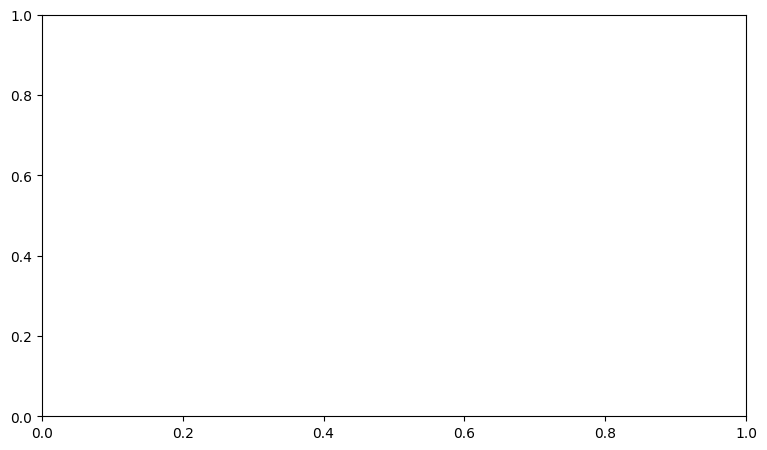

In [59]:
# Comprehensive Visualizations by Category
print("📊 CREATING CATEGORY-BASED VISUALIZATIONS")
print("="*45)

plt.style.use('default')
sns.set_palette("Set2")

categories = analysis_df['Category'].unique()
n_cat = len(categories)
fig, axes = plt.subplots(n_cat, 2, figsize=(18, 8 * n_cat))

if n_cat == 1:
    axes = np.array([axes])

for i, cat in enumerate(categories):
    cat_df = analysis_df[analysis_df['Category'] == cat]
    cat_valid_prices = cat_df[cat_df['price_numeric'] < 500000000]

    # 1. Price Distribution by Source for this Category
    ax1 = axes[i, 0]
    sns.histplot(data=cat_valid_prices, x='price_numeric', hue='source', bins=30, alpha=0.7, ax=ax1)
    ax1.set_title(f'Price Distribution by Source: {cat}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Price (PKR)')
    ax1.set_ylabel('Count')

    # 2. Top 10 Areas by Average Price for this Category
    cat_stats = category_stats_filtered.xs(cat, level='Category').sort_values('avg_price', ascending=False).head(10)
    ax2 = axes[i, 1]
    bars = ax2.barh(range(len(cat_stats)), cat_stats['avg_price'])
    ax2.set_yticks(range(len(cat_stats)))
    ax2.set_yticklabels(cat_stats.index)
    ax2.set_title(f'Top 10 Areas by Avg Price: {cat}', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Average Price (PKR)')
    for j, v in enumerate(cat_stats['avg_price']):
        ax2.text(v + v*0.02, j, f'{v/10000000:.1f}Cr', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Visualizations created successfully!")


In [ ]:
%pip install nbformat

import nbformat

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Interactive Plotly Visualizations
print("🎯 CREATING INTERACTIVE VISUALIZATIONS")
print("="*45)

# 1. Interactive Price Distribution by Location
fig_price_location = px.box(
    analysis_df[analysis_df['price_numeric'] < 300000000],  # Cap at 30 Crore PKR for better visualization
    x='location_standardized',
    y='price_numeric',
    color='source',
    title='Price Distribution by Location and Source (PKR)',
    labels={'price_numeric': 'Price (PKR)', 'location_standardized': 'Location'}
)

fig_price_location.update_xaxes(tickangle=45)
fig_price_location.update_layout(height=600, showlegend=True)
fig_price_location.show()

# 2. Interactive Bar Chart: Average Price by Location
location_avg_price = location_stats_filtered.head(15).reset_index()

fig_bar = px.bar(
    location_avg_price,
    x='location_standardized',
    y='avg_price',
    color='property_count',
    title='Average Price by Location (Top 15 Areas) - PKR',
    labels={'avg_price': 'Average Price (PKR)', 'location_standardized': 'Location'},
    hover_data=['property_count', 'median_price'],
    color_continuous_scale='Viridis'
)

fig_bar.update_xaxes(tickangle=45)
fig_bar.update_layout(height=500)
fig_bar.show()

# 3. Treemap: Property Count by Location
fig_treemap = px.treemap(
    location_stats_filtered.head(20).reset_index(),
    path=['location_standardized'],
    values='property_count',
    color='avg_price',
    title='Property Count by Location (Size) and Average Price in PKR (Color)',
    color_continuous_scale='RdYlBu_r'
)

fig_treemap.update_layout(height=600)
fig_treemap.show()

print("✅ Interactive visualizations created!")


🎯 CREATING INTERACTIVE VISUALIZATIONS


✅ Interactive visualizations created!


In [ ]:
# Market Insights and Key Findings
print("💡 LAHORE REAL ESTATE MARKET INSIGHTS")
print("="*50)

# Calculate key market metrics
total_properties = len(combined_df)
total_with_prices = len(analysis_df)
avg_market_price = analysis_df['price_numeric'].mean()
median_market_price = analysis_df['price_numeric'].median()

# Premium vs Affordable segments (all in PKR)
premium_threshold = 200000000  # 20 Crore PKR
affordable_threshold = 100000000  # 10 Crore PKR

premium_properties = analysis_df[analysis_df['price_numeric'] > premium_threshold]
affordable_properties = analysis_df[analysis_df['price_numeric'] < affordable_threshold]
mid_range_properties = analysis_df[
    (analysis_df['price_numeric'] >= affordable_threshold) & 
    (analysis_df['price_numeric'] <= premium_threshold)
]

print("🏆 KEY MARKET FINDINGS:")
print("="*40)

print(f"1. MARKET SIZE & SCOPE:")
print(f"   • Total Properties Analyzed: {total_properties:,}")
print(f"   • Properties with Price Data: {total_with_prices:,} ({total_with_prices/total_properties*100:.1f}%)")
print(f"   • Average Market Price: {avg_market_price:,.0f} PKR")
print(f"   • Median Market Price: {median_market_price:,.0f} PKR")

print(f"\n2. MARKET SEGMENTS (PKR):")
print(f"   • Affordable (<10 Cr): {len(affordable_properties):,} ({len(affordable_properties)/total_with_prices*100:.1f}%)")
print(f"   • Mid-Range (10-20 Cr): {len(mid_range_properties):,} ({len(mid_range_properties)/total_with_prices*100:.1f}%)")
print(f"   • Premium (>20 Cr): {len(premium_properties):,} ({len(premium_properties)/total_with_prices*100:.1f}%)")

# Most and least expensive areas
most_expensive = location_stats_filtered.head(3)
most_affordable = location_stats_filtered.tail(3)

print(f"\n3. PREMIUM LOCATIONS:")
for idx, (location, data) in enumerate(most_expensive.iterrows(), 1):
    print(f"   {idx}. {location}: {data['avg_price']:,.0f} PKR avg ({int(data['property_count'])} properties)")

print(f"\n4. AFFORDABLE LOCATIONS:")
for idx, (location, data) in enumerate(most_affordable.iterrows(), 1):
    print(f"   {idx}. {location}: {data['avg_price']:,.0f} PKR avg ({int(data['property_count'])} properties)")

# Source comparison
zameen_data = analysis_df[analysis_df['source'] == 'Zameen.com']
graana_data = analysis_df[analysis_df['source'] == 'Graana.com']

print(f"\n5. SOURCE COMPARISON:")
if len(zameen_data) > 0 and len(graana_data) > 0:
    print(f"   • Zameen.com: {len(zameen_data):,} properties, Avg: {zameen_data['price_numeric'].mean():,.0f} PKR")
    print(f"   • Graana.com: {len(graana_data):,} properties, Avg: {graana_data['price_numeric'].mean():,.0f} PKR")
    
    # Price difference
    price_diff = abs(zameen_data['price_numeric'].mean() - graana_data['price_numeric'].mean())
    print(f"   • Average Price Difference: {price_diff:,.0f} PKR")

print(f"\n📊 MARKET RECOMMENDATIONS:")
print("="*35)

print(f"🎯 FOR BUYERS:")
print(f"   • Best Value Areas: {', '.join(most_affordable.index[:2])}")
print(f"   • Largest Selection: {', '.join(location_stats_filtered.sort_values('property_count', ascending=False).head(2).index)}")
print(f"   • Budget-Friendly: Focus on properties under 10 Crore PKR ({len(affordable_properties)/total_with_prices*100:.1f}% of market)")

print(f"\n🏘️ FOR INVESTORS:")
print(f"   • Premium Growth Areas: {', '.join(most_expensive.index[:2])}")
print(f"   • High Activity Zones: {', '.join(location_stats_filtered.sort_values('property_count', ascending=False).head(3).index)}")
print(f"   • Emerging Markets: Areas with 10-50 properties for potential growth")

print(f"\n📱 FOR DATA SOURCES:")
zameen_count = len(combined_df[combined_df['source'] == 'Zameen.com'])
graana_count = len(combined_df[combined_df['source'] == 'Graana.com'])
print(f"   • Zameen.com: {zameen_count:,} properties ({zameen_count/total_properties*100:.1f}%)")
print(f"   • Graana.com: {graana_count:,} properties ({graana_count/total_properties*100:.1f}%)")
print(f"   • Combined Coverage: Comprehensive market view across both platforms")

print(f"\n✅ ANALYSIS COMPLETE!")
print(f"Total insights generated from {total_properties:,} property records")

💡 LAHORE REAL ESTATE MARKET INSIGHTS
🏆 KEY MARKET FINDINGS:
1. MARKET SIZE & SCOPE:
   • Total Properties Analyzed: 3,837
   • Properties with Price Data: 3,837 (100.0%)
   • Average Market Price: 38,100,397 PKR
   • Median Market Price: 14,200,000 PKR

2. MARKET SEGMENTS (PKR):
   • Affordable (<10 Cr): 3,500 (91.2%)
   • Mid-Range (10-20 Cr): 225 (5.9%)
   • Premium (>20 Cr): 112 (2.9%)

3. PREMIUM LOCATIONS:
   1. Samanabad, Lahore: 124,356,667 PKR avg (9 properties)
   2. Quaid-e-Azam Industrial Estate, Lahore: 116,380,000 PKR avg (5 properties)
   3. DHA: 69,308,968 PKR avg (1205 properties)

4. AFFORDABLE LOCATIONS:
   1. Faisal Town: 2,245,815 PKR avg (27 properties)
   2. DHA 9 Town - Block D, DHA 9 Town: 2,049,600 PKR avg (5 properties)
   3. Askari 11 - Sector C, Askari 11: 40,833 PKR avg (6 properties)

5. SOURCE COMPARISON:
   • Zameen.com: 2,323 properties, Avg: 45,834,144 PKR
   • Graana.com: 1,514 properties, Avg: 26,234,153 PKR
   • Average Price Difference: 19,599,990 

In [ ]:
# Export Results and Summary
print("💾 EXPORTING ANALYSIS RESULTS")
print("="*35)

# Create summary statistics for export
summary_stats = {
    'total_properties': len(combined_df),
    'properties_with_prices': len(analysis_df),
    'avg_market_price_pkr': analysis_df['price_numeric'].mean(),
    'median_market_price_pkr': analysis_df['price_numeric'].median(),
    'price_std_pkr': analysis_df['price_numeric'].std(),
    'zameen_properties': len(combined_df[combined_df['source'] == 'Zameen.com']),
    'graana_properties': len(combined_df[combined_df['source'] == 'Graana.com']),
    'unique_locations': combined_df['location_standardized'].nunique(),
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Export location statistics
location_stats_export = location_stats_filtered.copy()
location_stats_export['avg_price_crores'] = location_stats_export['avg_price'] / 10000000
location_stats_export['median_price_crores'] = location_stats_export['median_price'] / 10000000

# Save to CSV files
try:
    # Combined dataset
    combined_df.to_csv('combined_lahore_property_data.csv', index=False)
    print("✅ Combined dataset saved to: combined_lahore_property_data.csv")
    
    # Location statistics
    location_stats_export.to_csv('location_analysis_results.csv')
    print("✅ Location analysis saved to: location_analysis_results.csv")
    
    # Summary statistics
    pd.DataFrame([summary_stats]).to_csv('market_summary_stats.csv', index=False)
    print("✅ Market summary saved to: market_summary_stats.csv")
    
except Exception as e:
    print(f"❌ Error saving files: {e}")

# Display final summary
print(f"\n📋 FINAL ANALYSIS SUMMARY")
print("="*40)
print(f"📊 Dataset Overview:")
print(f"   • Combined Properties: {len(combined_df):,}")
print(f"   • Analysis-Ready Properties: {len(analysis_df):,}")
print(f"   • Unique Locations: {combined_df['location_standardized'].nunique()}")
print(f"   • Data Sources: {combined_df['source'].nunique()}")

print(f"\n💰 Market Insights:")
print(f"   • Average Price: {analysis_df['price_numeric'].mean()/10000000:.2f} Crores")
print(f"   • Price Range: {analysis_df['price_numeric'].min()/100000:.1f} - {analysis_df['price_numeric'].max()/10000000:.1f} Lac-Cr")
print(f"   • Most Expensive Area: {location_stats_filtered.index[0]} ({location_stats_filtered.iloc[0]['avg_price']/10000000:.2f} Cr avg)")
print(f"   • Highest Volume Area: {location_stats_filtered.sort_values('property_count', ascending=False).index[0]} ({int(location_stats_filtered.sort_values('property_count', ascending=False).iloc[0]['property_count'])} properties)")

print(f"\n📁 Generated Files:")
print(f"   1. combined_lahore_property_data.csv - Full combined dataset")
print(f"   2. location_analysis_results.csv - Location-wise statistics")  
print(f"   3. market_summary_stats.csv - Key market metrics")

print(f"\n🎯 Next Steps:")
print(f"   • Use combined dataset for further analysis")
print(f"   • Monitor price trends over time")
print(f"   • Expand analysis to other cities")
print(f"   • Integrate additional data sources")

print(f"\n✅ EDA ANALYSIS COMPLETE!")
print(f"🏠 Lahore Real Estate Market comprehensively analyzed")
print(f"📊 Ready for business insights and decision making")

💾 EXPORTING ANALYSIS RESULTS
✅ Combined dataset saved to: combined_lahore_property_data.csv
✅ Location analysis saved to: location_analysis_results.csv
✅ Market summary saved to: market_summary_stats.csv

📋 FINAL ANALYSIS SUMMARY
📊 Dataset Overview:
   • Combined Properties: 3,837
   • Analysis-Ready Properties: 3,837
   • Unique Locations: 449
   • Data Sources: 2

💰 Market Insights:
   • Average Price: 3.81 Crores
   • Price Range: 0.0 - 90.0 Lac-Cr
   • Most Expensive Area: Samanabad, Lahore (12.44 Cr avg)
   • Highest Volume Area: DHA (1205 properties)

📁 Generated Files:
   1. combined_lahore_property_data.csv - Full combined dataset
   2. location_analysis_results.csv - Location-wise statistics
   3. market_summary_stats.csv - Key market metrics

🎯 Next Steps:
   • Use combined dataset for further analysis
   • Monitor price trends over time
   • Expand analysis to other cities
   • Integrate additional data sources

✅ EDA ANALYSIS COMPLETE!
🏠 Lahore Real Estate Market comprehens